In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

In [3]:
def genGaussianSamples(N, m, C):
    A = np.linalg.cholesky(C)
    U = np.random.randn(N,2)
    return(U @ A.T + m)
# Define three means
#
Means = np.array([[0, 3], [3, 0], [4,4]])
# Define three covariance matrices ensuring
# they are positive definite
#
from sklearn.datasets import make_spd_matrix
CovMatrices = np.zeros((3,2,2))
for j in range(3):
    CovMatrices[j,:,:] = make_spd_matrix(2)
# Priors
#
w = np.random.rand(3)
w = w / np.sum(w)

# How many data in each component (1000 in total)
#
nData = np.floor(w * 1000).astype(int)
# Draw samples from each component
#
X0 = genGaussianSamples(nData[0], Means[0,:], CovMatrices[0,:,:])
X1 = genGaussianSamples(nData[1], Means[1,:], CovMatrices[1,:,:])
X2 = genGaussianSamples(nData[2], Means[2,:], CovMatrices[2,:,:])
# Append into an array for the data we need
#
X = np.append(np.append(X0, X1, axis=0), X2, axis=0)
print (X0.shape,X1.shape, X2.shape)
print (w[0],w[1],w[2])

(323, 2) (288, 2) (388, 2)
0.3231012781725394 0.2883124184906978 0.3885863033367629


In [4]:
# This function computes the Euclidean distance from a to b
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [6]:
import random
k=3
C1 = X[random.randint(0,X.shape[0])]
C2 = X[random.randint(0,X.shape[0])]
C3 = X[random.randint(0,X.shape[0])]
C = np.vstack ((C1, C2))
C = np.vstack ((C, C3))
clusters = np.zeros(len(X))
Cprev = np.zeros(C.shape)
error = dist(C, Cprev, None)
# Loop will run till the error becomes zero
iterations=0
centroids = []
#Loop stops when the error is zero
while error != 0:
    centroids.append(Cprev)
    # Assign each data to closest cluster
    for i in range(len(X)):
        distances = dist(X[i], C)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    # Storing the old centroid values
    Cprev = deepcopy(C)
    # Update Centroids with the mean value 
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    error = dist(C, Cprev, None)
    iterations=iterations+1
print('Number of iterations:',iterations)
centroids = np.array(centroids)
centroids1=np.reshape(centroids,(-1,2))

Number of iterations: 9


In [7]:
def gauss2D(x, m, C):
    Ci = np.linalg.inv (C)
    dC = np.linalg.det (C)
    num = np.exp (-0.5 * np.dot((x-m) .T, np.dot(Ci, (x-m))))
    den = 2 * np.pi * dC
    return num/den

def twoDGaussianPlot (nx, ny, m, C): 
    x = np.linspace (-5, 5, nx)
    y = np.linspace (-5, 5, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    Z = np.zeros ([nx, ny]) 
    for i in range (nx):
        for j in range(ny):
            xvec = np.array ([X[i,j], Y[i,j]])
            Z[i,j]= gauss2D(xvec, m, C)

    return X, Y, Z

nx, ny = 100,60

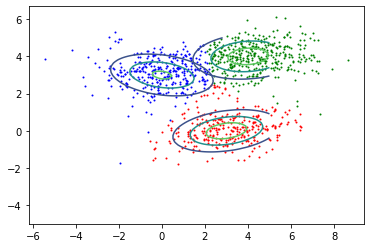

In [8]:
colors = ['r', 'g', 'b']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=1, c=colors[i])
        Xp, Yp, Zp = twoDGaussianPlot(nx,ny,Means[i,:],CovMatrices[i,:,:])
        plt.contour(Xp,Yp,Zp,3)
plt.savefig('clustered data')


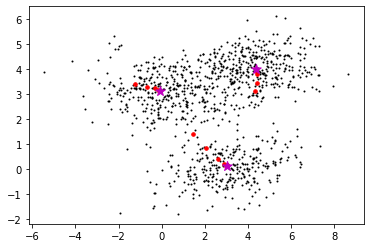

In [9]:
fig, ax = plt.subplots()
plt.scatter(X[:,0], X[:,1], c='black', s=1)
ax.scatter(centroids1[9:,0],centroids1[9:,1], marker='.', s=50, c='r')
ax.scatter(C[:, 0], C[:, 1], marker='*', s=100, c='m')
plt.savefig('centroids')

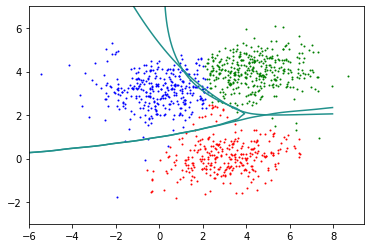

In [11]:
def posteriorPlot(nx, ny, m1, C1, m2, C2, m3, C3, P1, P2, P3): 
    x = np.linspace (-6, 8, nx)
    y = np.linspace (-6, 8, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    Z = np.zeros ([nx, ny])
    for i in range(nx):
        for j in range(ny):
            xvec = np.array ([X[i,j], Y[i,j]])
            num = P1*gauss2D(xvec, m1, C1)
            den = P1*gauss2D(xvec, m1, C1)+ P2*gauss2D(xvec, m2, C2)+ P3*gauss2D(xvec, m3, C3)
            Z[i,j]= num / den
    return X,Y,Z
xpos1, ypos1, zpos1 = posteriorPlot(nx, ny, Means[0,:], CovMatrices[0,:,:], Means[1,:], CovMatrices[1,:,:], Means[2,:],CovMatrices[1,:,:],  w[0], w[1], w[2])
xpos2, ypos2, zpos2 = posteriorPlot(nx, ny, Means[1,:], CovMatrices[1,:,:], Means[0,:], CovMatrices[0,:,:], Means[2,:],CovMatrices[1,:,:],  w[1], w[0], w[2])
xpos3, ypos3, zpos3 = posteriorPlot(nx, ny, Means[2,:], CovMatrices[2,:,:], Means[0,:], CovMatrices[0,:,:], Means[1,:],CovMatrices[1,:,:],  w[2], w[0], w[1])
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=1, c=colors[i])
        ax.set_ylim([-3, 7])
plt.contour (xpos1, ypos1, zpos1,1)
plt.contour (xpos2, ypos2, zpos2,1)
plt.contour (xpos3, ypos3, zpos3,1)
plt.savefig('posterior')

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
#sklearn implementation
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
CC=kmeans.cluster_centers_
mycenters=np.zeros((k,2))
mycenters[0] = centroids1[iterations*3-3,:]
mycenters[1] = centroids1[iterations*3-2,:]
mycenters[2] = centroids1[iterations*3-1,:]
a=0
r = [-1, -1, -1]
clusters=clusters.astype(np.int64)
#Here we match the clusters of our's and sklearn's 
#implementation in order to compare them and find the accuracy
for j in range(k):
        if (np.linalg.norm(mycenters[j]-CC[0])<=0.5):
            r[j]=0
        if (np.linalg.norm(mycenters[j]-CC[1])<=0.5):
            r[j]=1
        if (np.linalg.norm(mycenters[j]-CC[2])<=0.5):
            r[j]=2
for i in range(len(X)):
    a=clusters[i]
    clusters[i]=r[a]
        

sortedcenter = mycenters[mycenters[:,0].argsort()]
sortedCC = CC[CC[:,0].argsort()]
error=  mean_squared_error(sortedcenter, sortedCC)
print ('The accuracy is:',1-error)
c1=0
c2=0
c3=0
for i in range(len(X)):
    if clusters[i]==0:
        c1=c1+1
    if clusters[i]==1:
        c2=c2+1
    if clusters[i]==2:
        c3=c3+1
print (c1,c2,c3)

The accuracy is: 0.9999543448348385
297 366 336


In [13]:
a=0
c1=0
c2=0
c3=0
#Compute the assignment error between the 2 K-means
for i in range(len(X)):
    if (clusters[i]==kmeans.predict([X[i,:]])[0]):
        a=a+1
accuracy = a/X.shape[0]
print ('The assignment error is:',1-accuracy)
for i in range(len(X)):
    if kmeans.predict([X[i,:]])[0]==0:
        c1=c1+1
    if kmeans.predict([X[i,:]])[0]==1:
        c2=c2+1
    if kmeans.predict([X[i,:]])[0]==2:
        c3=c3+1
print (c1,c2,c3)

The assignment error is: 0.0
297 366 336


In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import csv
datafile = open('dataset_61_iris.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
data = []
for row in datareader:
    data.append(row)    
A = np.array(data)
B = A [1:151,0:4]
B = B.astype('float')
D = B[:,0:4]
classes = A[1:,4]
target = np.zeros(150)
# We transform our target vector to numeric 
for i in range(len(classes)):
    if classes[i]=='Iris-setosa':
        target[i]=0
    if classes[i]=='Iris-versicolor':
        target[i]=1
    if classes[i]=='Iris-virginica':
        target[i]=2

In [19]:
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)
#This exactly the same code as before

In [21]:
#This exactly the same code as before
import random
k=3
C1 = D[random.randint(0,D.shape[0])]
C2 = D[random.randint(0,D.shape[0])]
C3 = D[random.randint(0,D.shape[0])]
C = np.vstack ((C1, C2))
C = np.vstack ((C, C3))
clusters = np.zeros(len(D))
Cprev = np.zeros(C.shape)
error = dist(C, Cprev, None)
iterations=0
centroids = []
while error != 0:
    centroids.append(Cprev)
    for i in range(len(D)):
        distances = dist(D[i], C)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    Cprev = deepcopy(C)
    for i in range(k):
        points = [D[j] for j in range(len(D)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    error = dist(C, Cprev, None)
    iterations=iterations+1
print('Number of iterations:',iterations)
centroids = np.array(centroids)
centroids1=np.reshape(centroids,(-1,2))

Number of iterations: 4


In [22]:
clusters = clusters.astype(np.int64)
Class_1 = clusters[0:50]
Class_2 = clusters[50:100]
Class_3 = clusters[100:150]
counts1 = np.bincount(Class_1).argmax()
counts2 = np.bincount(Class_2).argmax()
counts3 = np.bincount(Class_3).argmax()
x=0
y=0
z=0
for i in range(len(Class_1)):
    if Class_1[i]==counts1:
        x=x+1
    if Class_2[i]==counts2:
        y=y+1
    if Class_3[i]==counts3:
        z=z+1
acc1 = (x+y+z)/D.shape[0]    
print ('The accuracy is:',acc1)

The accuracy is: 0.8933333333333333
